# Air Quality Prediction

[World's Air Pollution: Real-Time Air Quality Index](https://waqi.info/)

https://aqicn.org/json-api/doc/

## Prepare environment

In [1]:
import os

import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy.signal import periodogram

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import torch
import torch.nn as nn
import torch.optim as optim

# Load environment variables
from dotenv import load_dotenv
load_dotenv()

# Make random numbers stable for reproduction
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Add sources to the path
import sys
from pathlib import Path
PROJECT_ROOT = str(Path().resolve().parent)
sys.path.append(PROJECT_ROOT)

from src.data import aqi, meteo
from src.data.calendar import add_calendar_features
from src.data.features import FeatureScaler, split_to_windows, flatten_windows, _flatten_windows # TODO: don't use internal methods
from src.model.training import split_data
from src.model.evaluation import evaluate_predictions, print_prediction_metrics
from src.model.inference import recursive_forecasting
from src.model import xgboost
from src.hopsworks.client import HopsworksClient
from src.common import LOGGER_NAME

import logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(name)s - %(message)s"
)

LOGGER = logging.getLogger(LOGGER_NAME)
LOGGER.setLevel(logging.DEBUG)

## Configuration

In [2]:
# How many (lagged) days to use as input during training
historical_window_size = 3
# How many days to teach the model to predict 
prediction_window_size = 3
# TODO: use recursive_forecasting boolean instead
# How many predictions to do as part of recursive forecasting
num_of_predictions = 1

## Prepare data

### Load data

In [3]:
aqi_df = aqi.load_data(PROJECT_ROOT)

2025-08-02 12:56:24,025 INFO: Initializing external client
2025-08-02 12:56:24,027 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-08-02 12:56:25,463 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1239207
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.58s) 


In [4]:
# Make sure column names are stripped
aqi_columns = aqi_df.columns
aqi_columns

Index(['pm25', 'pm10', 'no2', 'so2', 'co'], dtype='object')

In [5]:
aqi_df.head()

,pm25,pm10,no2,so2,co
2021-12-27,NaN,37.0,25.0,2.0,12.0
2021-12-28,105.0,36.0,21.0,3.0,9.0
2021-12-29,104.0,26.0,17.0,1.0,10.0
2021-12-30,73.0,17.0,8.0,1.0,9.0
2021-12-31,56.0,6.0,5.0,1.0,12.0


In [6]:
aqi_df.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])

,pm25,pm10,no2,so2,co
count,1312.000000,1313.000000,1304.000000,1218.000000,1306.000000
mean,44.771442,15.064531,5.573435,3.138345,3.993886
std,18.205264,7.752356,3.752169,1.690886,1.554045
min,10.000000,2.000000,1.000000,1.000000,1.000000
25%,31.000000,10.000000,3.000000,2.000000,3.000000
50%,43.000000,14.000000,5.000000,3.000000,4.000000
75%,56.000000,19.000000,7.000000,4.000000,5.000000
90%,68.000000,25.000000,11.000000,5.000000,6.000000
95%,76.000000,29.000000,13.000000,6.000000,7.000000
max,117.000000,90.000000,27.000000,15.000000,12.000000


### Handle missing dates

In [7]:
aqi_df = aqi.clean_missing_dates(aqi_df)

2025-08-02 12:56:30,032 DEBUG: Missing dates: DatetimeIndex(['2024-12-30'], dtype='datetime64[ns]', freq='D')
2025-08-02 12:56:30,038 DEBUG: Missing dates after cleanup: DatetimeIndex([], dtype='datetime64[ns]', freq='D')


### Handle N/A values

In [8]:
aqi_df = aqi.clean_missing_values(aqi_df)

2025-08-02 12:56:30,058 DEBUG: Missing values:
pm25     2
pm10     2
no2     11
so2     97
co       9
dtype: int64
2025-08-02 12:56:30,064 DEBUG: Missing values after cleaning:
pm25    0
pm10    0
no2     0
so2     0
co      0
dtype: int64


## Feature engineering

### Calendar Features

In [9]:
aqi_df = add_calendar_features(aqi_df)
aqi_df.head()

,pm25,pm10,no2,so2,co,year,month,day_of_month,day_of_week,day_of_year,week_of_year,is_leap_year,is_working_day,is_feb29
2021-12-27,43.0,37.0,25.0,2.0,12.0,2021,12,27,0,361,52,0,1,0
2021-12-28,105.0,36.0,21.0,3.0,9.0,2021,12,28,1,362,52,0,1,0
2021-12-29,104.0,26.0,17.0,1.0,10.0,2021,12,29,2,363,52,0,1,0
2021-12-30,73.0,17.0,8.0,1.0,9.0,2021,12,30,3,364,52,0,1,0
2021-12-31,56.0,6.0,5.0,1.0,12.0,2021,12,31,4,365,52,0,1,0


### Cyclical features

TODO: 
For cyclical features (month, day_of_week, hour, day_of_year), it's often better to transform them
into sine and cosine components to preserve the cyclical nature and avoid arbitrary ordinal relationships.

### Meteorological data

[Meteorological Parameters](https://dev.meteostat.net/formats.html#meteorological-parameters)

In [10]:
weather_df = meteo.fetch_daily_data(aqi_df)
weather_df.head()

,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres
time,,,,,,,,
2021-12-27,-13.1,-17.2,-8.0,<NA>,<NA>,2.7,13.0,1009.1
2021-12-28,-9.3,-13.8,-2.0,<NA>,<NA>,4.0,13.0,1006.6
2021-12-29,-4.1,-8.1,-0.9,<NA>,<NA>,4.8,14.8,1005.6
2021-12-30,-3.6,-9.6,1.8,<NA>,<NA>,4.7,13.0,1015.0
2021-12-31,3.9,-0.2,8.2,<NA>,<NA>,15.2,33.3,1017.1


In [11]:
weather_df.describe()

,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres
count,1315.0,1315.0,1315.0,1180.0,4.0,1315.0,1304.0,1315.0
mean,7.959392,2.677719,13.232928,2.157034,2.0,12.474981,26.574233,1016.189734
std,8.002204,7.390893,9.133112,4.494391,1.414214,6.62445,9.259978,7.967264
min,-13.1,-20.2,-8.0,0.0,1.0,2.6,11.1,987.5
25%,1.2,-2.95,6.0,0.0,1.0,7.8,20.4,1011.55
50%,7.9,3.0,13.2,0.1,1.5,10.4,24.1,1016.6
75%,14.8,8.7,20.9,2.2,2.5,15.3,31.5,1021.2
max,24.5,18.4,34.0,42.7,4.0,47.8,57.4,1039.8


In [12]:
weather_df = meteo.clean_missing_values(weather_df)

2025-08-02 12:56:30,356 DEBUG: Missing values:
tavg       0
tmin       0
tmax       0
prcp     135
snow    1311
wspd       0
wpgt      11
pres       0
dtype: int64
2025-08-02 12:56:30,368 DEBUG: Missing values after cleaning:
tavg    0
tmin    0
tmax    0
prcp    0
snow    0
wspd    0
wpgt    0
pres    0
dtype: int64


In [13]:
merged_df = pd.merge_asof(aqi_df, weather_df, left_index=True, right_index=True)

In [14]:
merged_df.head()

,pm25,pm10,no2,so2,co,year,month,day_of_month,day_of_week,day_of_year,...,is_working_day,is_feb29,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres
2021-12-27,43.0,37.0,25.0,2.0,12.0,2021,12,27,0,361,...,1,0,-13.1,-17.2,-8.0,0.0,0.0,2.7,13.0,1009.1
2021-12-28,105.0,36.0,21.0,3.0,9.0,2021,12,28,1,362,...,1,0,-9.3,-13.8,-2.0,0.0,0.0,4.0,13.0,1006.6
2021-12-29,104.0,26.0,17.0,1.0,10.0,2021,12,29,2,363,...,1,0,-4.1,-8.1,-0.9,0.0,0.0,4.8,14.8,1005.6
2021-12-30,73.0,17.0,8.0,1.0,9.0,2021,12,30,3,364,...,1,0,-3.6,-9.6,1.8,0.0,0.0,4.7,13.0,1015.0
2021-12-31,56.0,6.0,5.0,1.0,12.0,2021,12,31,4,365,...,1,0,3.9,-0.2,8.2,0.0,0.0,15.2,33.3,1017.1


In [15]:
all_columns = merged_df.columns

### Target columns

In [16]:
target_columns = all_columns
# target_columns = aqi_columns

### Convert all features to float

Converting all features to floats is a fundamental preprocessing step for neural networks. It ensures compatibility with the underlying mathematical operations, facilitates normalization, and aligns with the requirements of deep learning frameworks.

In [17]:
merged_df = merged_df.astype(float)

In [18]:
merged_df.dtypes

pm25              float64
pm10              float64
no2               float64
so2               float64
co                float64
year              float64
month             float64
day_of_month      float64
day_of_week       float64
day_of_year       float64
week_of_year      float64
is_leap_year      float64
is_working_day    float64
is_feb29          float64
tavg              float64
tmin              float64
tmax              float64
prcp              float64
snow              float64
wspd              float64
wpgt              float64
pres              float64
dtype: object

## Explore trends

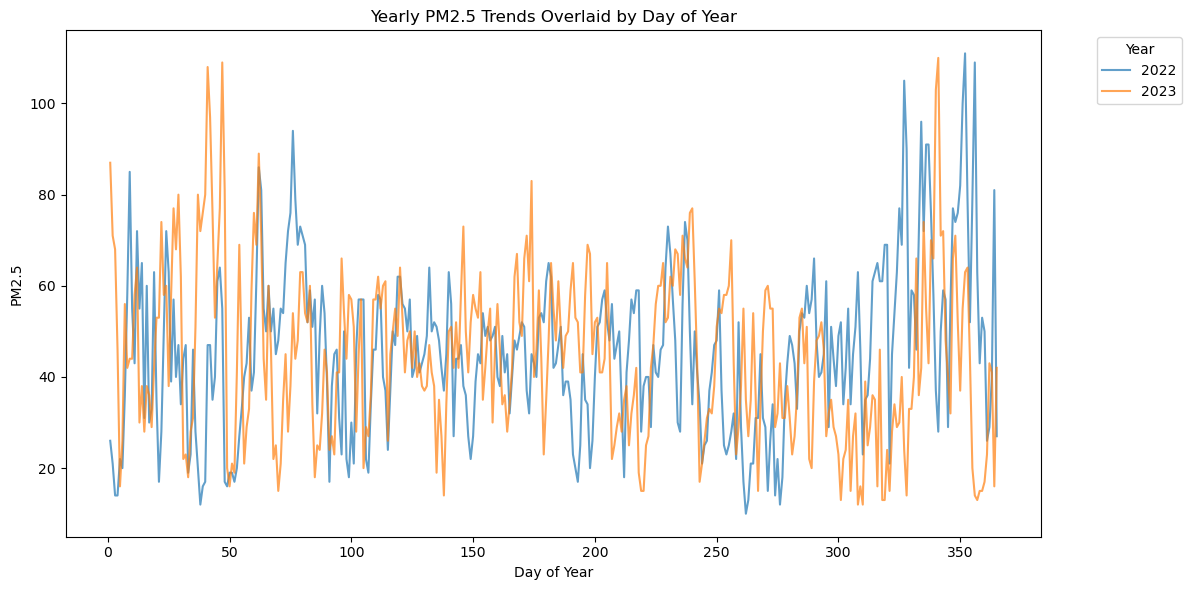

In [19]:
plt.figure(figsize=(12, 6))
for year, group in aqi_df.groupby("year"):
    if (year in [2022, 2023]):
        plt.plot(group["day_of_year"], group["pm25"], label=str(year), alpha=0.7)

plt.xlabel("Day of Year")
plt.ylabel("PM2.5")
plt.title("Yearly PM2.5 Trends Overlaid by Day of Year")
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<Figure size 1000x500 with 0 Axes>

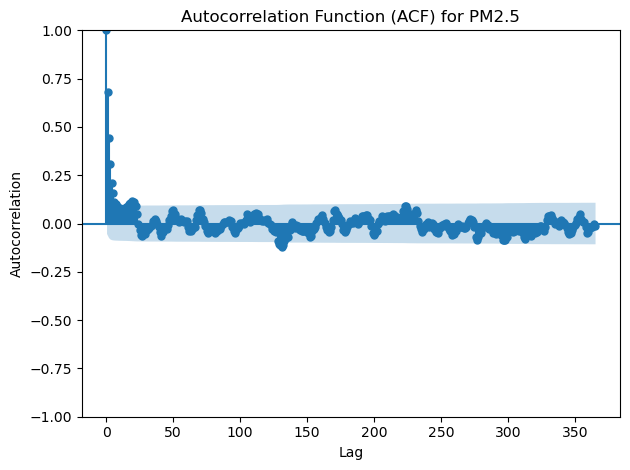

In [20]:
plt.figure(figsize=(10, 5))
plot_acf(aqi_df["pm25"], lags=365)
plt.title("Autocorrelation Function (ACF) for PM2.5")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.show()

2025-08-02 12:56:30,955 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-08-02 12:56:30,965 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


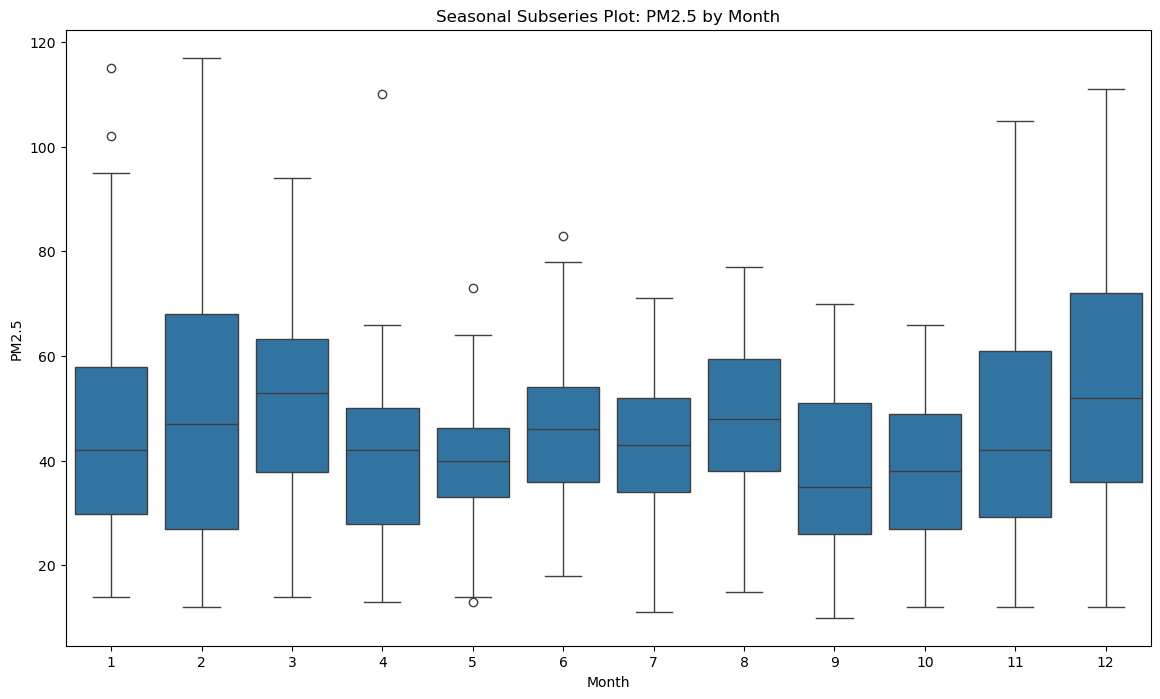

In [21]:
plt.figure(figsize=(14, 8))
sns.boxplot(x="month", y="pm25", data=aqi_df)
plt.title("Seasonal Subseries Plot: PM2.5 by Month")
plt.xlabel("Month")
plt.ylabel("PM2.5")
plt.show()

<Figure size 1400x1000 with 0 Axes>

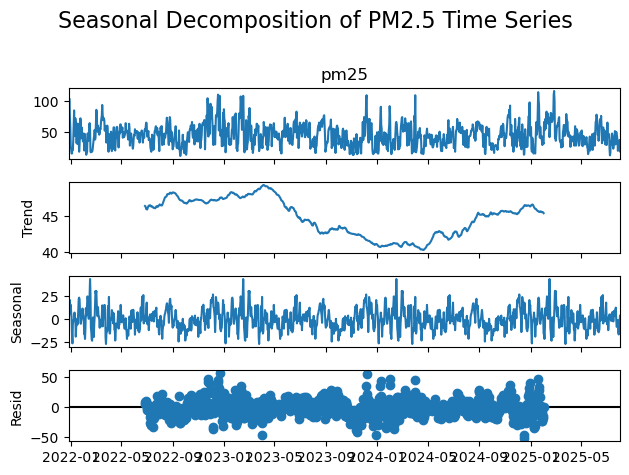

In [22]:
# Ensure pm25 is float and has no missing values for decomposition
pm25_series = aqi_df["pm25"].astype(float).interpolate()

result = seasonal_decompose(pm25_series, model='additive', period=365)

plt.figure(figsize=(14, 10))
result.plot()
plt.suptitle("Seasonal Decomposition of PM2.5 Time Series", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

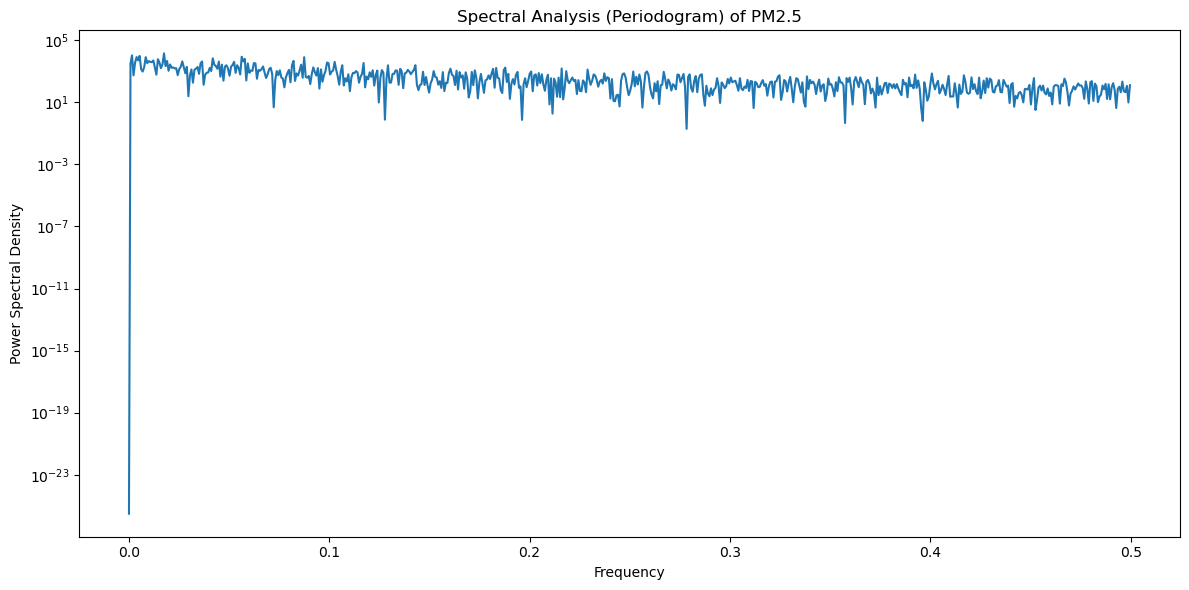

In [23]:
# Fill missing values in pm25 for spectral analysis
pm25_filled = aqi_df["pm25"].astype(float).values

# Compute the periodogram
freqs, power = periodogram(pm25_filled)

plt.figure(figsize=(12, 6))
plt.semilogy(freqs, power)
plt.title("Spectral Analysis (Periodogram) of PM2.5")
plt.xlabel("Frequency")
plt.ylabel("Power Spectral Density")
plt.tight_layout()
plt.show()

## Split Data into Training, Validation, and Test Sets

In [24]:
train_df, val_df, test_df = split_data(merged_df)

## Feature Scaling

Not strictly required for tree-based models (Random Forest, Gradient Boosting like XGBoost/LightGBM) as they are scale-invariant, but also don't hurt performance of these models.
However, it is a must for Neural Networks.

In [25]:
feature_scaler = FeatureScaler()
feature_scaler.fit(train_df)

train_df = feature_scaler.transform(train_df)
val_df = feature_scaler.transform(val_df)
test_df = feature_scaler.transform(test_df)

In [26]:
train_df.head()

,pm25,pm10,no2,so2,co,year,month,day_of_month,day_of_week,day_of_year,...,is_working_day,is_feb29,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres
2021-12-27,-0.085599,2.831088,5.225180,-0.721988,5.794265,-2.386276,1.695463,1.279396,-1.496739,1.798122,...,1.0,0.0,-2.702724,-2.772244,-2.383468,-0.476609,-0.0414,-1.451668,-1.453518,-0.850354
2021-12-28,3.380018,2.701799,4.153766,-0.147021,3.710786,-2.386276,1.695463,1.392508,-0.997034,1.807874,...,1.0,0.0,-2.224257,-2.308611,-1.722775,-0.476609,-0.0414,-1.259109,-1.453518,-1.160956
2021-12-29,3.324121,1.408908,3.082352,-1.296955,4.405279,-2.386276,1.695463,1.505621,-0.497330,1.817627,...,1.0,0.0,-1.569512,-1.531344,-1.601648,-0.476609,-0.0414,-1.140611,-1.259914,-1.285197
2021-12-30,1.591313,0.245305,0.671671,-1.296955,3.710786,-2.386276,1.695463,1.618733,0.002375,1.827379,...,1.0,0.0,-1.506556,-1.735888,-1.304336,-0.476609,-0.0414,-1.155423,-1.453518,-0.117332
2021-12-31,0.641063,-1.176875,-0.131890,-1.296955,5.794265,-2.386276,1.695463,1.731846,0.502080,1.837131,...,1.0,0.0,-0.562213,-0.454080,-0.599596,-0.476609,-0.0414,0.399859,0.729898,0.143574


## Prepare prediction windows

In [27]:
(
    X_window_train,
    X_window_val,
    X_window_test,
    y_window_train,
    y_window_val,
    y_window_test,
) = split_to_windows(
    train_df, val_df, test_df, historical_window_size, prediction_window_size, target_columns=target_columns
)

In [28]:
X_window_train[-1]

,pm25,pm10,no2,so2,co,year,month,day_of_month,day_of_week,day_of_year,...,is_working_day,is_feb29,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres
2024-11-07,1.535416,2.184642,2.010938,-0.721988,1.627306,1.294607,1.397497,-0.982852,0.002375,1.320252,...,1.0,0.0,-1.002907,-1.108620,-0.368353,-0.476609,-0.0414,-1.170235,-1.453518,2.056885
2024-11-08,1.814901,1.667486,1.743085,-0.721988,1.627306,1.294607,1.397497,-0.869740,0.502080,1.330004,...,1.0,0.0,-0.977724,-1.135893,-0.324307,-0.476609,-0.0414,-1.036926,-1.453518,1.969916
2024-11-09,1.759004,1.538197,1.207378,-0.721988,1.627306,1.294607,1.397497,-0.756627,1.001784,1.339757,...,0.0,0.0,-0.902177,-1.313164,-0.071041,-0.476609,-0.0414,-1.066550,-1.453518,1.584769


In [29]:
y_window_train[-1]

,pm25,pm10,no2,so2,co,year,month,day_of_month,day_of_week,day_of_year,...,is_working_day,is_feb29,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres
2024-11-10,1.814901,2.831088,2.814499,-0.721988,2.321799,1.294607,1.397497,-0.643515,1.501489,1.349509,...,0.0,0.0,-1.229549,-1.476799,-0.533527,-0.476609,-0.0414,-1.140611,-1.453518,1.336287
2024-11-11,2.317974,1.667486,1.475231,-0.721988,1.627306,1.294607,1.397497,-0.530403,-1.496739,1.359261,...,1.0,0.0,-1.191775,-1.408618,-0.511504,-0.476609,-0.0414,-0.977677,-1.259914,1.299015
2024-11-12,1.591313,2.572510,0.939524,-0.721988,0.932813,1.294607,1.397497,-0.417290,-0.997034,1.369014,...,1.0,0.0,-1.204366,-1.285891,-0.951966,-0.476609,-0.0414,-0.977677,-1.453518,1.212046


## Training and Evaluation

In [30]:
# Flatten for regressors
X_flat_train, X_flat_val, X_flat_test, y_flat_train, y_flat_val, y_flat_test = flatten_windows(X_window_train, X_window_val, X_window_test, y_window_train, y_window_val, y_window_test)

In [31]:
X_flat_train[-1]

array([ 1.53541554,  2.18464238,  2.01093829, -0.72198826,  1.62730591,
        1.294607  ,  1.39749687, -0.98285225,  0.00237502,  1.32025166,
        1.32093723,  1.        ,  1.        ,  0.        , -1.00290653,
       -1.10862012, -0.36835329, -0.47660939, -0.04139999, -1.17023548,
       -1.45351775,  2.05688477,  1.81490081,  1.66748582,  1.74308477,
       -0.72198826,  1.62730591,  1.294607  ,  1.39749687, -0.86973984,
        0.50207964,  1.33000411,  1.32093723,  1.        ,  1.        ,
        0.        , -0.97772405, -1.13589263, -0.32430707, -0.47660939,
       -0.04139999, -1.03692553, -1.45351775,  1.96991609,  1.75900375,
        1.53819667,  1.20737774, -0.72198826,  1.62730591,  1.294607  ,
        1.39749687, -0.75662743,  1.00178426,  1.33975656,  1.32093723,
        1.        ,  0.        ,  0.        , -0.90217662, -1.31316401,
       -0.07104128, -0.47660939, -0.04139999, -1.06654996, -1.45351775,
        1.5847691 ])

In [32]:
y_flat_train[-1]

array([ 1.81490081,  2.83108809,  2.81449884, -0.72198826,  2.32179914,
        1.294607  ,  1.39749687, -0.64351501,  1.50148888,  1.34950901,
        1.32093723,  1.        ,  0.        ,  0.        , -1.22954883,
       -1.47679912, -0.53352663, -0.47660939, -0.04139999, -1.14061104,
       -1.45351775,  1.33628717,  2.31797429,  1.66748582,  1.47523125,
       -0.72198826,  1.62730591,  1.294607  ,  1.39749687, -0.5304026 ,
       -1.49673884,  1.35926146,  1.38923359,  1.        ,  1.        ,
        0.        , -1.19177511, -1.40861782, -0.51150352, -0.47660939,
       -0.04139999, -0.97767667, -1.25991441,  1.29901488,  1.59131259,
        2.57250981,  0.93952422, -0.72198826,  0.93281268,  1.294607  ,
        1.39749687, -0.41729019, -0.99703422,  1.36901391,  1.38923359,
        1.        ,  1.        ,  0.        , -1.20436635, -1.28589149,
       -0.95196575, -0.47660939, -0.04139999, -0.97767667, -1.45351775,
        1.2120462 ])

### XGBoost

In [33]:
multi_regressor = xgboost.create_regressor()
multi_regressor.fit(X_flat_train, y_flat_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None, ...))

In [34]:
actual, predictions = recursive_forecasting(multi_regressor, test_df, historical_window_size, prediction_window_size, num_of_predictions, torch=False)

predictions = [feature_scaler.inverse_transform(prediction) for prediction in predictions]
actual = [feature_scaler.inverse_transform(value) for value in actual]

flat_predictions = _flatten_windows(predictions)
flat_actual = _flatten_windows(actual)

xgboost_prediction_metrics = evaluate_predictions(y_true=flat_actual, y_pred=flat_predictions, window_size=prediction_window_size*num_of_predictions)
print_prediction_metrics(xgboost_prediction_metrics, target_columns)

2025-08-02 12:56:47,148 WARNING: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

2025-08-02 12:56:53,075 INFO: Day 1:
2025-08-02 12:56:53,076 INFO: 	Metrics for pm25:
2025-08-02 12:56:53,078 INFO: 	 RMSE: 8.3409
2025-08-02 12:56:53,079 INFO: 	 R2_Score: 0.6384
2025-08-02 12:56:53,080 INFO: --------------------
2025-08-02 12:56:53,081 INFO: 	Metrics for pm10:
2025-08-02 12:56:53,081 INFO: 	 RMSE: 4.2063
2025-08-02 12:56:53,082 INFO: 	 R2_Score: 0.1585
2025-08-02 12:56:53,083 INFO: --------------------
2025-08-02 12:56:53,083 INFO: 	Metrics for no2:
2025-08-02 12:56:53,084 INFO: 	 RMSE: 1.5229
2025-08-02 12:56:53,085 INFO: 	 R2_Score: 0.0969
2025-08-02 12:56:53,086 INFO: --------------------
2025-08-02 12:56:53,087 INFO: 	Metrics for so2:
2025-0

In [35]:
feature_names = []
for i in reversed(range(historical_window_size)):
    for column in merged_df.columns:
        feature_names.append(f"{column}_lag_{i + 1}d")

In [36]:
# Extract feature importance from each target model
importance_df = pd.DataFrame()

for i, target_name in enumerate(merged_df.columns):  # Replace with your target names
    estimator = multi_regressor.estimators_[i]
    importance_df[target_name] = estimator.feature_importances_

# Set feature names as index
importance_df.index = feature_names  # Set index to feature names

# Display top features for each target
for target in importance_df.columns:
    print(f"\n{target} - Top 10 Features:")
    target_imp = importance_df[target].sort_values(ascending=False).head(10)
    for i, (feat, score) in enumerate(target_imp.items()):
        print(f"{i+1:2d}. {feat:<20} : {score:.4f}")

# Overall top features (averaged across all targets)
overall_top = importance_df.mean(axis=1).sort_values(ascending=False).head(10)
print(f"\nOverall Top 10 Features:")
for i, (feat, score) in enumerate(overall_top.items()):
    print(f"{i+1:2d}. {feat:<20} : {score:.4f}")


pm25 - Top 10 Features:
 1. pm10_lag_1d          : 0.2998
 2. pm25_lag_1d          : 0.1920
 3. no2_lag_1d           : 0.0739
 4. tmax_lag_1d          : 0.0279
 5. pres_lag_1d          : 0.0196
 6. is_feb29_lag_1d      : 0.0187
 7. month_lag_1d         : 0.0170
 8. week_of_year_lag_1d  : 0.0161
 9. day_of_year_lag_1d   : 0.0152
10. tmax_lag_2d          : 0.0142

pm10 - Top 10 Features:
 1. pm10_lag_1d          : 0.1207
 2. day_of_year_lag_1d   : 0.0482
 3. no2_lag_1d           : 0.0396
 4. month_lag_2d         : 0.0385
 5. pm10_lag_2d          : 0.0331
 6. pm25_lag_1d          : 0.0326
 7. pm25_lag_2d          : 0.0316
 8. pres_lag_1d          : 0.0303
 9. is_working_day_lag_1d : 0.0240
10. co_lag_1d            : 0.0227

no2 - Top 10 Features:
 1. no2_lag_1d           : 0.2209
 2. tavg_lag_1d          : 0.1217
 3. day_of_year_lag_1d   : 0.0438
 4. tmin_lag_1d          : 0.0386
 5. year_lag_1d          : 0.0339
 6. tavg_lag_2d          : 0.0261
 7. day_of_year_lag_2d   : 0.0213
 8. tma

### Neural Networks

In [37]:
class EarlyStopping:
    """Early stopping utility to monitor validation loss and save best weights"""

    def __init__(self, patience=10, min_delta=1e-6, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights

        self.best_loss = float("inf")
        self.counter = 0
        self.best_weights = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            # Validation loss improved
            self.best_loss = val_loss
            self.counter = 0
            # Save best weights
            if self.restore_best_weights:
                self.best_weights = {
                    k: v.clone().detach() for k, v in model.state_dict().items()
                }
        else:
            # No improvement
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

        return self.early_stop

    def restore_best_weights_to_model(self, model):
        """Restore the best weights to the model"""
        if self.best_weights is not None:
            model.load_state_dict(self.best_weights)
            print(f"Restored best weights (val_loss: {self.best_loss:.6f})")

In [38]:
# Prepare data for LSTM: convert windowed data to tensors
def windows_to_tensor(X_windows, y_windows):
    # X: list of DataFrames, each (window_size, num_features)
    # y: list of DataFrames, each (prediction_window_size, num_targets)
    X_tensor = torch.tensor(
        np.stack([x.values for x in X_windows]), dtype=torch.float32
    )
    y_tensor = torch.tensor(
        np.stack([y.values for y in y_windows]), dtype=torch.float32
    )
    return X_tensor, y_tensor

In [39]:
X_lstm_train, y_lstm_train = windows_to_tensor(X_window_train, y_window_train)
X_lstm_val, y_lstm_val = windows_to_tensor(X_window_val, y_window_val)
X_lstm_test, y_lstm_test = windows_to_tensor(X_window_test, y_window_test)

In [40]:
X_lstm_train.shape

torch.Size([1047, 3, 22])

In [41]:
y_lstm_train.shape

torch.Size([1047, 3, 22])

In [42]:
class LSTMRegressor(nn.Module):

    def __init__(
        self, input_dim, hidden_dim, output_dim, num_layers=1, prediction_window_size=3
    ):
        super().__init__()

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.1)
        self.dropout = nn.Dropout(0.5)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)

        self.fc = nn.Linear(hidden_dim, output_dim * prediction_window_size)
        
        self.output_dim = output_dim
        self.prediction_window_size = prediction_window_size

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        out, _ = self.lstm(x)
        # Use last hidden state for prediction
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.batch_norm(out)
        out = self.fc(out)
        # Reshape to (batch, prediction_window_size, output_dim)
        out = out.view(-1, self.prediction_window_size, self.output_dim)
        return out

In [43]:
input_dim = X_lstm_train.shape[2]
output_dim = y_lstm_train.shape[2]
hidden_dim = 64
num_layers = 2
prediction_window_size = y_lstm_train.shape[1]

model = LSTMRegressor(
    input_dim, hidden_dim, output_dim, num_layers, prediction_window_size
)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
early_stopping = EarlyStopping(patience=15, min_delta=1e-6)

# Training loop
epochs = 1000
batch_size = 64

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_lstm_train.size(0))
    epoch_loss = 0
    for i in range(0, X_lstm_train.size(0), batch_size):
        idx = permutation[i : i + batch_size]
        batch_X, batch_y = X_lstm_train[idx], y_lstm_train[idx]
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_X.size(0)
    epoch_loss /= X_lstm_train.size(0)

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_output = model(X_lstm_val)
        val_loss = criterion(val_output, y_lstm_val).item()
    
    # Print progress
    print(
        f"Epoch {epoch+1}/{epochs} | "
        f"Train Loss: {epoch_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Best Val: {early_stopping.best_loss:.6f}"
    )
    
    # Early stopping check
    if early_stopping(val_loss, model):
        best_epoch = epoch + 1 - early_stopping.patience
        print(f"\nEarly stopping triggered at epoch {epoch + 1}")
        print(f"Best epoch was {best_epoch} with val_loss: {early_stopping.best_loss:.6f}")
        break

    # Update best epoch if this is the best so far
    if val_loss == early_stopping.best_loss:
        best_epoch = epoch + 1

# Restore best weights
early_stopping.restore_best_weights_to_model(model)

# Training completed
final_status = "Early stopped" if early_stopping.early_stop else "Completed"
print(f"\nTraining {final_status.lower()} after {epoch + 1} epochs")
print(f"Best validation loss: {early_stopping.best_loss:.6f} at epoch {best_epoch}")

Epoch 1/1000 | Train Loss: 1.0392 | Val Loss: 1.3496 | Best Val: inf
Epoch 2/1000 | Train Loss: 0.7861 | Val Loss: 1.1191 | Best Val: 1.349610
Epoch 3/1000 | Train Loss: 0.6943 | Val Loss: 0.8636 | Best Val: 1.119145
Epoch 4/1000 | Train Loss: 0.6430 | Val Loss: 0.7322 | Best Val: 0.863631
Epoch 5/1000 | Train Loss: 0.6064 | Val Loss: 0.6735 | Best Val: 0.732155
Epoch 6/1000 | Train Loss: 0.5850 | Val Loss: 0.6398 | Best Val: 0.673511
Epoch 7/1000 | Train Loss: 0.5597 | Val Loss: 0.6306 | Best Val: 0.639787
Epoch 8/1000 | Train Loss: 0.5417 | Val Loss: 0.6271 | Best Val: 0.630564
Epoch 9/1000 | Train Loss: 0.5271 | Val Loss: 0.6093 | Best Val: 0.627142
Epoch 10/1000 | Train Loss: 0.5154 | Val Loss: 0.6165 | Best Val: 0.609339
Epoch 11/1000 | Train Loss: 0.5043 | Val Loss: 0.6035 | Best Val: 0.609339
Epoch 12/1000 | Train Loss: 0.4934 | Val Loss: 0.6047 | Best Val: 0.603509
Epoch 13/1000 | Train Loss: 0.4907 | Val Loss: 0.5846 | Best Val: 0.603509
Epoch 14/1000 | Train Loss: 0.4841 | Va

In [44]:
actual, predictions = recursive_forecasting(model, test_df, historical_window_size, prediction_window_size, num_of_predictions, torch=True)

predictions = [feature_scaler.inverse_transform(prediction) for prediction in predictions]
actual = [feature_scaler.inverse_transform(value) for value in actual]

flat_predictions = _flatten_windows(predictions)
flat_actual = _flatten_windows(actual)

lstm_prediction_metrics = evaluate_predictions(y_true=flat_actual, y_pred=flat_predictions, window_size=prediction_window_size*num_of_predictions)
print_prediction_metrics(lstm_prediction_metrics, target_columns)

2025-08-02 12:56:57,817 WARNING: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

2025-08-02 12:56:59,212 INFO: Day 1:
2025-08-02 12:56:59,212 INFO: 	Metrics for pm25:
2025-08-02 12:56:59,213 INFO: 	 RMSE: 10.1117
2025-08-02 12:56:59,213 INFO: 	 R2_Score: 0.4685
2025-08-02 12:56:59,214 INFO: --------------------
2025-08-02 12:56:59,215 INFO: 	Metrics for pm10:
2025-08-02 12:56:59,216 INFO: 	 RMSE: 4.1293
2025-08-02 12:56:59,216 INFO: 	 R2_Score: 0.1890
2025-08-02 12:56:59,217 INFO: --------------------
2025-08-02 12:56:59,218 INFO: 	Metrics for no2:
2025-08-02 12:56:59,218 INFO: 	 RMSE: 1.6635
2025-08-02 12:56:59,219 INFO: 	 R2_Score: -0.0775
2025-08-02 12:56:59,220 INFO: --------------------
2025-08-02 12:56:59,221 INFO: 	Metrics for so2:
2025

## Save Model

In [45]:
metrics = {}
for days_index, day_metrics in enumerate(xgboost_prediction_metrics):
    for column_index, aqi in enumerate(aqi_columns):
        for (metric_name, metric_value) in day_metrics[column_index].items():
            metrics[f"Day_{days_index+1}_{aqi}_{metric_name}"] = round(metric_value, 4)

In [46]:
metrics = {}
for column_index, aqi in enumerate(aqi_columns):
    aqi_metrics = {}

    for days_index, day_metrics in enumerate(xgboost_prediction_metrics):
        for (metric_name, metric_value) in day_metrics[column_index].items():
            aqi_metrics.setdefault(metric_name, []).append(metric_value)
    
    for aqi_metric_name, aqi_metric_value in aqi_metrics.items():
        metrics[f"{aqi}_{aqi_metric_name}"] = round(sum(aqi_metric_value) / len(aqi_metric_value), 4)

In [47]:
hopsworks_model = HopsworksClient().save_model(PROJECT_ROOT, multi_regressor, metrics, X_flat_test[0], y_flat_test[0], feature_scaler)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/feature_scaler.bin: 0.000%|          | 0/18…

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/predictor.py: 0.000%|          | 0/4484 ela…

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/requirements.txt: 0.000%|          | 0/119 …

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/aqi_prediction_model.pkl: 0.000%|          …

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/src/utils.py: 0.000%|          | 0/214 elap…

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/src/common.py: 0.000%|          | 0/38 elap…

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/src/__init__.py: 0.000%|          | 0/0 ela…

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/src/data/calendar.py: 0.000%|          | 0/…

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/src/data/features.py: 0.000%|          | 0/…

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/src/data/meteo.py: 0.000%|          | 0/119…

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/src/data/__init__.py: 0.000%|          | 0/…

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/src/data/aqi.py: 0.000%|          | 0/2071 …

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/src/model/xgboost.py: 0.000%|          | 0/…

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/src/model/inference.py: 0.000%|          | …

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/src/model/evaluation.py: 0.000%|          |…

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/src/model/__init__.py: 0.000%|          | 0…

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/src/model/training.py: 0.000%|          | 0…

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/src/hopsworks/client.py: 0.000%|          |…

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/src/hopsworks/__init__.py: 0.000%|         …

Uploading /home/martin/Workspace/Air-Quality-Prediction/notebooks/input_example.json: 0.000%|          | 0/125…

Uploading /home/martin/Workspace/Air-Quality-Prediction/notebooks/model_schema.json: 0.000%|          | 0/207 …

Model created, explore it at https://c.app.hopsworks.ai:443/p/1239207/models/aqi_prediction_model/20


## Real world prediction

In [48]:
# TODO: disabled for fast iteration
# hopsworks_model, multi_regressor = HopsworksClient().load_model(version=hopsworks_model.version)

In [49]:
# TODO: move to inference module

# Take last {historical_window_size} items for {prediction_window_size} predictions 
X = merged_df[-historical_window_size:]
X = feature_scaler.transform(X)

for day_index in range(num_of_predictions):
    # Input expects multiple windows
    X_flat = _flatten_windows([X])

    y_pred = multi_regressor.predict(X_flat)

    # Split y_pred into 3 arrays, one for each prediction day
    y_pred_split = np.split(y_pred.flatten(), prediction_window_size)

    # Create DataFrame for predictions, each row is a prediction day
    predictions_df = pd.DataFrame(y_pred_split, columns=target_columns)

    # Set the index to continue from the last date in merged_df
    last_date = X.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=prediction_window_size, freq="D")
    predictions_df.index = future_dates

    # Add predictions to the end so that we can use them as input (don't forget to remove the same number of items as we added - model expects certain size)
    X = pd.concat([X[prediction_window_size:], predictions_df], axis=0)

X = feature_scaler.inverse_transform(X)

# Definition of Air Quality Index is maximum value of Individual Air Quality Indexes
iaqi_features = ["pm25", "pm10", "no2", "so2", "co"]
X["aqi"] = X[iaqi_features].max(axis=1)

result = X[-num_of_predictions*prediction_window_size:][iaqi_features]

print(result)

2025-08-02 12:57:45,935 WARNING: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

                 pm25       pm10       no2       so2        co
2025-08-03  25.591349  17.119265  8.403215  5.751562  2.780210
2025-08-04  50.720352  24.421497  5.591865  3.039863  2.795023
2025-08-05  51.436005  19.620298  9.146380  2.635914  3.967841


## Hopsworks deployment

In [50]:
environment_api = HopsworksClient().project.get_environment_api()
# Unfortunately, environment has to be created through UI for now
environment = environment_api.get_environment("aqi-inference-pipeline-v1")
environment

Environment('aqi-inference-pipeline-v1')

In [51]:
# requirements_path = os.path.join(hopsworks_model.version_path, "Files", "requirements.txt")
# environment.install_requirements(requirements_path, await_installation=True)

In [52]:
predictor_script_path = os.path.join(hopsworks_model.version_path, "Files", "predictor.py")

In [53]:
import shutil
import pandas as pd
import joblib

import hopsworks

from hsml.schema import Schema
from hsml.model_schema import ModelSchema
from hsml.model_registry import ModelRegistry
from hsml.deployment import Deployment
from hsml.resources import PredictorResources, Resources
from hsml.model import Model

predictor_res = PredictorResources(
    num_instances=0,
    requests=Resources(cores=0.5, memory=512, gpus=0),
    limits=Resources(cores=0.5, memory=1024, gpus=0),
)

deployment_name = "aqipredictionmodeldeployment"

model_serving = HopsworksClient().project.get_model_serving()
deployment: Deployment = model_serving.get_deployment(deployment_name)
if deployment:
    deployment.stop()
    deployment.delete()

hopsworks_model: Model = hopsworks_model
deployment = hopsworks_model.deploy(
    name=deployment_name,
    script_file=predictor_script_path,
    resources=predictor_res,
    environment="aqi-inference-pipeline-v1"
)

  0%|          | 0/2 [00:00<?, ?it/s]

Deployment deleted successfully
Deployment created, explore it at https://c.app.hopsworks.ai:443/p/1239207/deployments/380940
Before making predictions, start the deployment by using `.start()`


In [54]:
# deployment = HopsworksClient().deploy_model(hopsworks_model, overwrite=True)
# deployment.describe()

In [55]:
deployment.start(await_running=300)
# make predictions
predictions = deployment.predict({"instances":[["not_empty"]]})
print(predictions)
deployment.stop(await_stopped=180)

  0%|          | 0/5 [00:00<?, ?it/s]

Start making predictions by using `.predict()`
2025-08-02 12:58:31,693 WARNING: UserWarning: Failed to patch SSL settings for unverified requests (unsupported version of urllib3?)
This may lead to errors when urllib3 tries to modify verify_mode.
Please report an issue at https://gitlab.com/alelec/pip-system-certs with your
python version included in the description


{'predictions': '{"pm25":{"1754179200000":24.010969162,"1754265600000":30.1325435638,"1754352000000":28.4693832397},"pm10":{"1754179200000":7.6625919342,"1754265600000":9.3634796143,"1754352000000":8.9966697693},"no2":{"1754179200000":3.0725767612,"1754265600000":3.3747158051,"1754352000000":3.5976169109},"so2":{"1754179200000":2.3633189201,"1754265600000":2.7339897156,"1754352000000":3.2384684086},"co":{"1754179200000":4.0944848061,"1754265600000":3.5764758587,"1754352000000":3.8381485939}}'}


  0%|          | 0/3 [00:00<?, ?it/s]

In [57]:
deployment.get_logs(component='predictor')

Deployment not running, explore historical logs at https://c.app.hopsworks.ai:443/p/1239207/deployments/380940
